## Coding

In [1]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install seaborn --upgrade


In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_multi_class_sentiment.csv")


In [5]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


text          0
label         0
label_name    0
dtype: int64

In [7]:
df['label'].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

## Dataset Analysis

In [8]:
import matplotlib.pyplot as plt


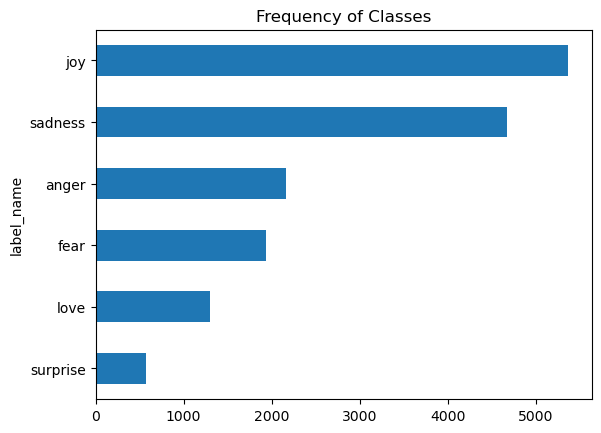

In [11]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<AxesSubplot:title={'center':'Words per Tweet'}, xlabel='label_name'>

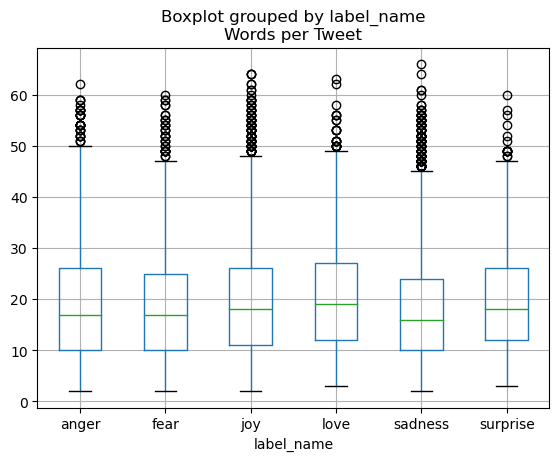

In [13]:
df['Words per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name")

## Text to Tokens Conversion
- Transformer models like BERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors.
- Tokenization is the step of breaking down a string into the atomic units used in the model

In [15]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


text = "I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [19]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

## Data Loader and Train Test Split

In [25]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

In [27]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train':Dataset.from_pandas(train, preserve_index=False),
     'test':Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }
     
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

## Tokenization of the Emotion/Sentiment Data

In [34]:
dataset['train'][0], dataset['train'][1]

({'text': 'i feel im being generous with that statement',
  'label': 2,
  'label_name': 'love',
  'Words per Tweet': 8},
 {'text': 'i make them feel valued and included even when we don t see each other often that it s one of my superpowers',
  'label': 1,
  'label_name': 'joy',
  'Words per Tweet': 23})

In [33]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2514, 10047, 2108, 12382, 2007, 2008, 4861, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2191, 2068, 2514, 11126, 1998, 2443, 2130, 2043, 2057, 2123, 1056, 2156, 2169, 2060, 2411, 2008, 2009, 1055, 2028, 1997, 2026, 3565, 11452, 2015, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [35]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [39]:
# label2id, id2label
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'love': 2, 'joy': 1, 'sadness': 0, 'fear': 4, 'anger': 3, 'surprise': 5},
 {2: 'love', 1: 'joy', 0: 'sadness', 4: 'fear', 3: 'anger', 5: 'surprise'})

## Model Building

In [41]:
from transformers import AutoModel 
import torch

In [43]:
model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [48]:
model.config.id2label
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## Fine-Tuning Transformers

In [50]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [55]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "bert_base_train_dir"

training_args = TrainingArguments( output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm = False
)

In [57]:
# Build compute metrics function
# !pip install evaluate
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



In [58]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}


## Build Model and Trainer

In [62]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_encoded['train'],
                  eval_dataset = emotion_encoded['validation'],
                  tokenizer = tokenizer)

In [63]:
trainer.train()

  0%|          | 0/350 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.4704403281211853, 'eval_accuracy': 0.85125, 'eval_f1': 0.8406753408569184, 'eval_runtime': 4.4954, 'eval_samples_per_second': 355.92, 'eval_steps_per_second': 5.561, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2951655387878418, 'eval_accuracy': 0.909375, 'eval_f1': 0.9079348228696951, 'eval_runtime': 4.1915, 'eval_samples_per_second': 381.729, 'eval_steps_per_second': 5.965, 'epoch': 2.0}
{'train_runtime': 1374.5377, 'train_samples_per_second': 16.296, 'train_steps_per_second': 0.255, 'train_loss': 0.6777776227678571, 'epoch': 2.0}


TrainOutput(global_step=350, training_loss=0.6777776227678571, metrics={'train_runtime': 1374.5377, 'train_samples_per_second': 16.296, 'train_steps_per_second': 0.255, 'train_loss': 0.6777776227678571, 'epoch': 2.0})

## Model Evaluation

In [64]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

  0%|          | 0/50 [00:00<?, ?it/s]

{'test_loss': 0.2910054922103882,
 'test_accuracy': 0.9028125,
 'test_f1': 0.9010784813634883,
 'test_runtime': 78.7905,
 'test_samples_per_second': 40.614,
 'test_steps_per_second': 0.635}

In [69]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       933
           1       0.91      0.92      0.91      1072
           2       0.79      0.74      0.76       261
           3       0.94      0.93      0.93       432
           4       0.86      0.87      0.87       387
           5       0.89      0.61      0.72       115

    accuracy                           0.90      3200
   macro avg       0.89      0.84      0.86      3200
weighted avg       0.90      0.90      0.90      3200



In [71]:
label2id

{'love': 2, 'joy': 1, 'sadness': 0, 'fear': 4, 'anger': 3, 'surprise': 5}

In [72]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

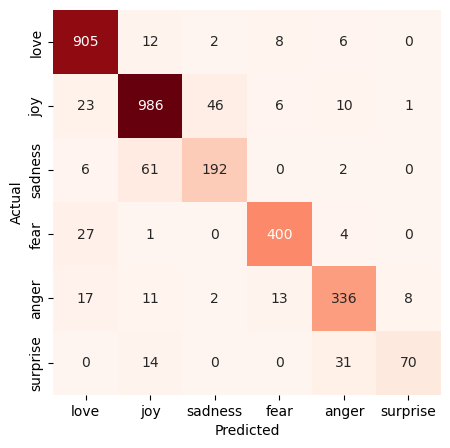

In [78]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Build Prediction Function and Store Model

In [86]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        outputs = model(**input_encoded)

    logits = outputs.logits

    pred = torch.argmax(logits, dim=1).item()
    return id2label[pred]

get_prediction(text)

'joy'

In [87]:
trainer.save_model("bert-base-uncased-sentiment-model")


In [93]:
# use pipeline for prediciton
from transformers import pipeline

classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')

classifier([text, 'hello, how are you?', "love you", "i am feeling low"])

[{'label': 'joy', 'score': 0.9631468057632446},
 {'label': 'joy', 'score': 0.7542405128479004},
 {'label': 'love', 'score': 0.6492504477500916},
 {'label': 'sadness', 'score': 0.9719626307487488}]